# Do Survey Methods Matter? : Opt-In Surveys and Extreme Responses 


### In March 2024 Pew Reasearch published an article about the various issues they found with Opt-in Polls: [Online opt-in polls can produce misleading results](https://www.pewresearch.org/short-reads/2024/03/05/online-opt-in-polls-can-produce-misleading-results-especially-for-young-people-and-hispanic-adults/)

#### This got me thinking about how survey methodologies can influence the extermity of responses to favorability polls and piqued my intrest to discover if a relationship between survey methodolgy and extreme responses exist.

#### For this analysis, I chose a truncated version of the dataset used in an another research article from Pew: [Assessing the Risks to Online Polls From Bogus Respondents](https://www.pewresearch.org/methods/2020/02/18/assessing-the-risks-to-online-polls-from-bogus-respondents/)

#### The Analysis questions that i aim to investigate are:
##### 1. Do opt-in suverys contain more extreme responses than other survey methods
##### 2. Do opt-in suverys skew meanigfully in a positive or negative direction
##### 3. Do the number of positive extreme responses have any meanigful relationship to the number of negative responses. 


### Alright Enough reading let's first, let's import and clean some data!!!

In [297]:
pip install scikit-learn

   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.6 MB 8.6 MB/s eta 0:00:02
   --- ------------------------------------ 0.9/10.6 MB 11.6 MB/s eta 0:00:01
   ------- -------------------------------- 1.9/10.6 MB 15.2 MB/s eta 0:00:01
   ------------ --------------------------- 3.4/10.6 MB 19.9 MB/s eta 0:00:01
   ------------------- -------------------- 5.2/10.6 MB 23.7 MB/s eta 0:00:01
   --------------------------- ------------ 7.2/10.6 MB 27.1 MB/s eta 0:00:01
   ----------------------------- ---------- 7.9/10.6 MB 25.3 MB/s eta 0:00:01
   ------------------------------------ --- 9.6/10.6 MB 26.7 MB/s eta 0:00:01
   ---------------------------------------  10.6/10.6 MB 31.2 MB/s eta 0:00:01
   ---------------------------------------- 10.6/10.6 MB 27.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   ---------------------- ---------------- 174.1/301.2 kB 10.2 MB/s eta 0:00:0

In [308]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
from scipy.stats import gaussian_kde
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn import metrics
from IPython.display import display, Math

df_raw = pd.read_csv('Survey_Sample_Data.csv') 

In [309]:
#Let's investigate what this dataset looks like

In [310]:
df_raw.head()

,RESPID,SOURCE,WEIGHT,PRESAPP,GLOBALFAVa,GLOBALFAVb,GLOBALFAVc,GLOBALFAVd,GLOBALFAVe,FLAG_BOGUS_RESPONDENT
0,ID_42681,ABS Panel 1,0.418318,Strongly disapprove,Very unfavorable,Mostly favorable,Mostly unfavorable,Mostly unfavorable,Very unfavorable,Not flagged
1,ID_27742,Opt-in Panel 3,1.034079,Strongly disapprove,Very unfavorable,Never heard of,Never heard of,Never heard of,Very unfavorable,Not flagged
2,ID_48187,ABS Panel 1,1.013228,Somewhat disapprove,Mostly unfavorable,Mostly favorable,Mostly favorable,Mostly favorable,Mostly favorable,Not flagged
3,ID_45048,Opt-in Panel 3,0.494696,Somewhat approve,Mostly favorable,Mostly favorable,Mostly favorable,Mostly favorable,Mostly favorable,Flagged
4,ID_50879,ABS Panel 1,0.985945,Somewhat disapprove,Mostly unfavorable,Never heard of,Never heard of,Mostly favorable,Mostly unfavorable,Not flagged


In [311]:
#While in the orginal article a lot of anlaysis went into deduce how to label a respondent as 'bogus'. But, for our annalysis here we will remove these respondents from out dataset

In [312]:
df_cleaned = df_raw.loc[df_raw['FLAG_BOGUS_RESPONDENT'] !='Flagged']
#now lets see if this worked
df_cleaned.head()

,RESPID,SOURCE,WEIGHT,PRESAPP,GLOBALFAVa,GLOBALFAVb,GLOBALFAVc,GLOBALFAVd,GLOBALFAVe,FLAG_BOGUS_RESPONDENT
0,ID_42681,ABS Panel 1,0.418318,Strongly disapprove,Very unfavorable,Mostly favorable,Mostly unfavorable,Mostly unfavorable,Very unfavorable,Not flagged
1,ID_27742,Opt-in Panel 3,1.034079,Strongly disapprove,Very unfavorable,Never heard of,Never heard of,Never heard of,Very unfavorable,Not flagged
2,ID_48187,ABS Panel 1,1.013228,Somewhat disapprove,Mostly unfavorable,Mostly favorable,Mostly favorable,Mostly favorable,Mostly favorable,Not flagged
4,ID_50879,ABS Panel 1,0.985945,Somewhat disapprove,Mostly unfavorable,Never heard of,Never heard of,Mostly favorable,Mostly unfavorable,Not flagged
5,ID_30449,Opt-in Panel 3,0.589633,Strongly disapprove,Very unfavorable,Mostly favorable,Mostly unfavorable,Mostly favorable,Mostly unfavorable,Not flagged


In [313]:
# now lets create a new column Opt_in to see if the classify the values from the source column. 1 being and opt-in survey 0 not. 

In [314]:
df_cleaned['Opt_in'] = (df_cleaned['SOURCE'].str.lower().str.contains("opt-in")).astype(int)


C:\Users\mmcdo\AppData\Local\Temp\ipykernel_4624\640248330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Opt_in'] = (df_cleaned['SOURCE'].str.lower().str.contains("opt-in")).astype(int)


In [315]:
df = df_cleaned.copy()
df = df.drop(columns=['FLAG_BOGUS_RESPONDENT'])
check_cols = ['PRESAPP', 'GLOBALFAVa', 'GLOBALFAVb', 'GLOBALFAVc', 'GLOBALFAVd', 'GLOBALFAVe']
df = df[~df[check_cols].isin(['Refused']).any(axis=1)]


In [316]:


#fav_ranking_dict = {'Very favorable':1,'Mostly favorable':2, 'Never heard of':None,'Mostly unfavorable':3,'Very unfavorable':4,'Refused':None}
fav_ranking_dict = {'Very favorable':1,'Mostly favorable':2, 'Never heard of':3,'Mostly unfavorable':4,'Very unfavorable':5}
#app_ranking_dict = {'Strongly disapprove':5, 'Somewhat disapprove':4, 'Somewhat approve':1,'Strongly approve':2, 'Refused':3}
app_ranking_dict = {'Strongly disapprove':4, 'Somewhat disapprove':3, 'Somewhat approve':2,'Strongly approve':1}


df['Press_Fav_Score'] = [app_ranking_dict[val] for val in df['PRESAPP']]*df['WEIGHT']
df['Qa_score']  = [fav_ranking_dict[val] for val in df['GLOBALFAVa']]*df['WEIGHT']
df['Qb_score']  = [fav_ranking_dict[val] for val in df['GLOBALFAVb']]*df['WEIGHT']
df['Qc_score']  = [fav_ranking_dict[val] for val in df['GLOBALFAVc']]*df['WEIGHT']
df['Qd_score']  = [fav_ranking_dict[val] for val in df['GLOBALFAVd']]*df['WEIGHT']
df['Qe_score']  = [fav_ranking_dict[val] for val in df['GLOBALFAVe']]*df['WEIGHT']




In [317]:
response_cols = ['Qa_score','Qb_score','Qc_score','Qd_score','Qe_score']
#df['Extreme_response'] = df[['Qa_score','Qb_score','Qc_score','Qd_score','Qe_score']].isin([1, 4]).sum(axis=1)
df['Extreme_Pos_Response'] = (df[response_cols] <= 1).sum(axis=1) *df['WEIGHT']
df['Extreme_Neg_Response'] = (df[response_cols] >= 4).sum(axis=1)  *df['WEIGHT']



In [318]:
summary_stats = df.groupby(['SOURCE','Opt_in'])[['Extreme_Pos_Response','Extreme_Neg_Response']].describe()
#summary_stats = summary_stats.drop(columns=[ 'min', '25%', '50%', '75%', 'max'])
summary_stats

Extreme_Pos_Response                                \
                                     count      mean       std  min  25%   
SOURCE         Opt_in                                                      
ABS Panel 1    0                    9437.0  0.367957  0.510239  0.0  0.0   
ABS Panel 2    0                    9867.0  0.410241  0.464475  0.0  0.0   
Crowd sourced  0                   10012.0  0.414803  0.466452  0.0  0.0   
Opt-in Panel 1 1                    9389.0  0.286754  0.486491  0.0  0.0   
Opt-in Panel 2 1                    9625.0  0.378111  0.530824  0.0  0.0   
Opt-in Panel 3 1                   10430.0  0.305074  0.498008  0.0  0.0   

                                                    Extreme_Neg_Response  \
                            50%       75%       max                count   
SOURCE         Opt_in                                                      
ABS Panel 1    0       0.000000  0.753952  3.807147               9437.0   
ABS Panel 2    0       0.260480  0.799185  2.909103               9867.0   
Crowd sourced  0       0.314883  0.775078  3.327215              10012.0   
Opt-in Panel 1 1       0.000000  0.542353  3.944467               9389.0   
Opt-in Panel 2 1       0.000000  0.776908  3.898382               9625.0   
Opt-in Panel 3 1       0.000000  0.581262  3.140278              10430.0   

                                                                               
                           mean       std  min  25%  50%       75%        max  
SOURCE         Opt_in                                                          
ABS Panel 1    0       2.317136  5.130223  0.0  0.0  0.0  1.928778  28.239924  
ABS Panel 2    0       2.802819  6.036035  0.0  0.0  0.0  2.568235  33.735625  
Crowd sourced  0       3.055561  8.674703  0.0  0.0  0.0  0.949783  55.096308  
Opt-in Panel 1 1       2.304378  3.963067  0.0  0.0  0.0  2.861934  21.221135  
Opt-in Panel 2 1       2.421340  5.229542  0.0  0.0  0.0  2.119489  30.443841  
Opt-in Panel 3 1       2.481769  4.477592  0.0  0.0  0.0  3.045534  24.353862

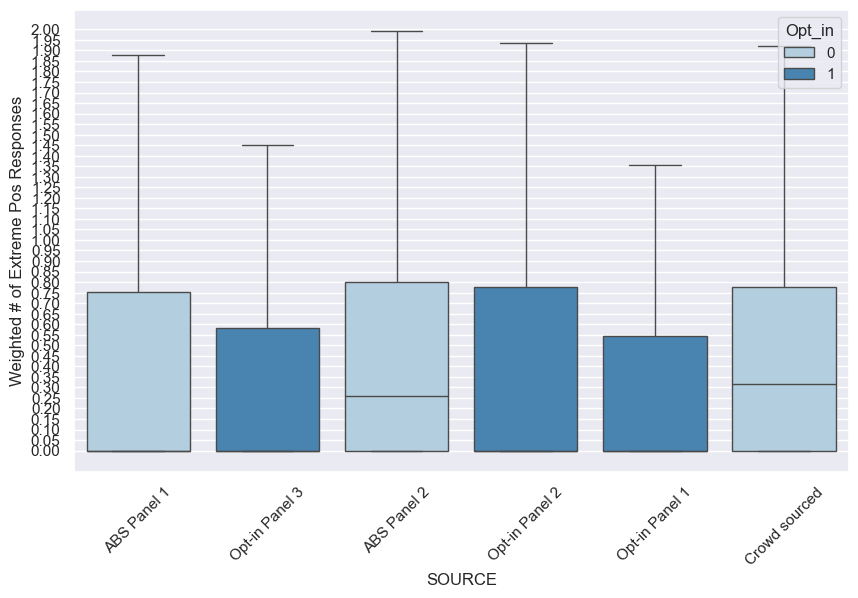

In [319]:
# Create a boxplot without showing individual data points
plt.figure(figsize=(10, 6)) 
ax = sns.boxplot(x='SOURCE', y='Extreme_Pos_Response', data=df, showfliers=False, hue='Opt_in',palette="Blues")
plt.xticks(rotation=45)
plt.yticks(np.linspace(0, 2, num=41))  # Set y-ticks range from 0 to 5 in increments of 0.2
plt.xlabel('SOURCE')
plt.ylabel('Weighted # of Extreme Pos Responses')
plt.legend(title='Opt_in', loc='upper right') 
plt.show()

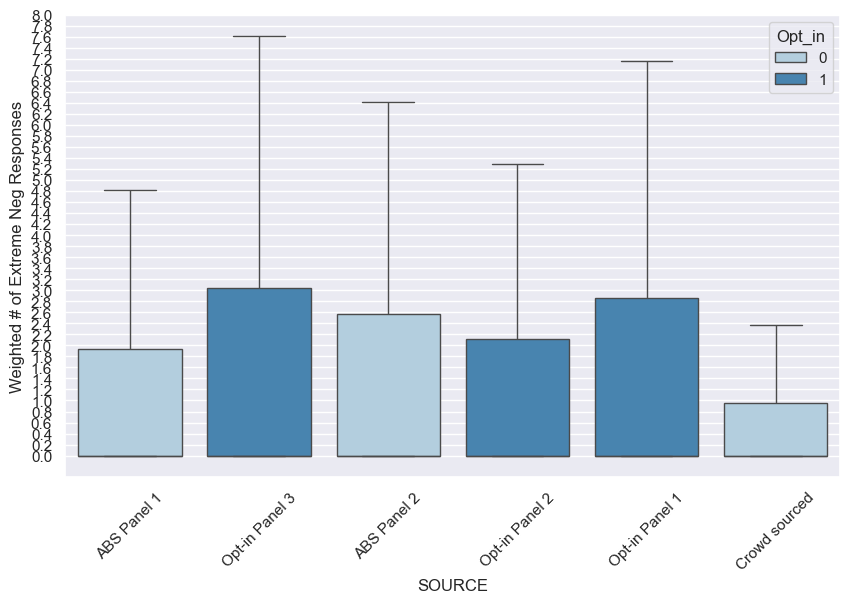

In [320]:
# Create a boxplot without showing individual data points
plt.figure(figsize=(10, 6)) 
ax = sns.boxplot(x='SOURCE', y='Extreme_Neg_Response', data=df, showfliers=False, hue='Opt_in',palette="Blues")
plt.xticks(rotation=45)
plt.yticks(np.linspace(0, 8, num=41))  # Set y-ticks range from 0 to 5 in increments of 0.2
plt.xlabel('SOURCE')
plt.ylabel('Weighted # of Extreme Neg Responses')
plt.legend(title='Opt_in', loc='upper right') 
plt.show()

In [321]:
df_opt_in = df.loc[df['Opt_in']==1]
df_not_opt_in = df.loc[df['Opt_in']==0]

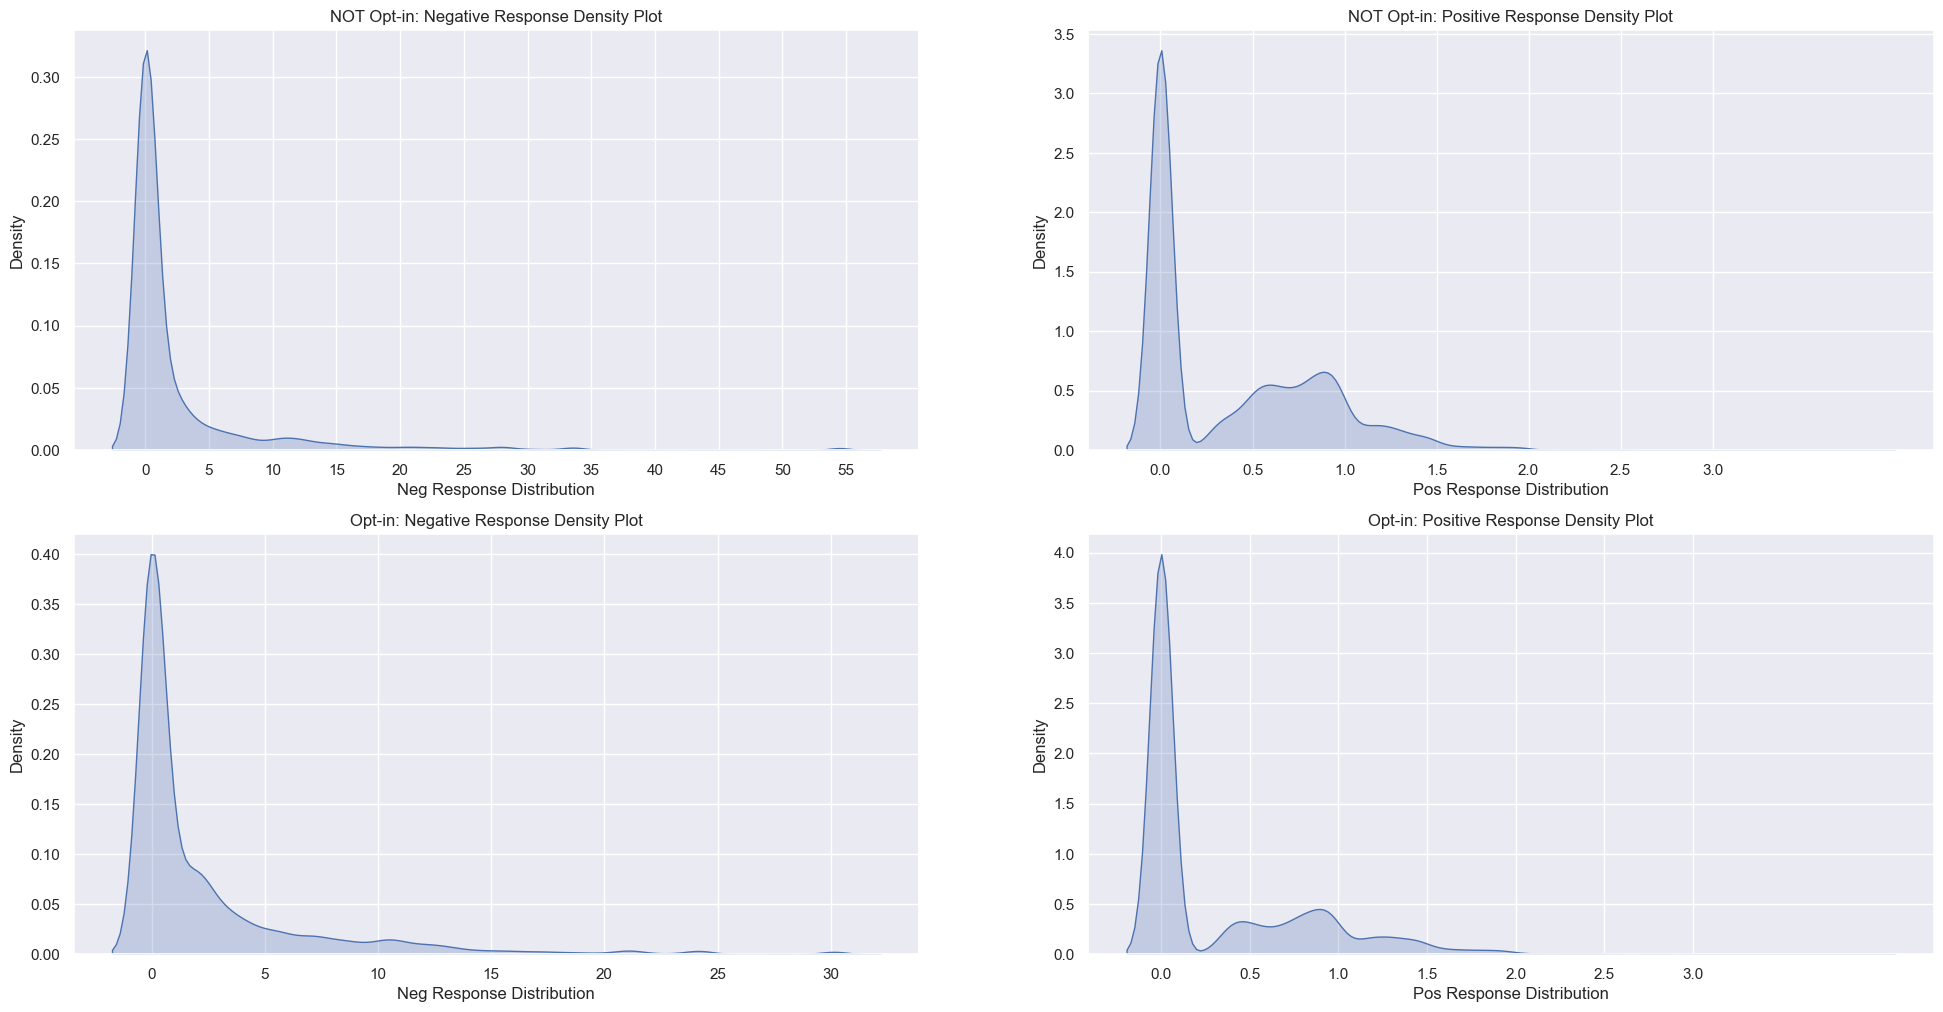

In [322]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 12))

sns.set_theme(style="darkgrid")
sns.kdeplot(data = df_not_opt_in['Extreme_Neg_Response'], fill=True,ax=ax1)
ax1.set_xlabel('Neg Response Distribution')
ax1.set_title('NOT Opt-in: Negative Response Density Plot')
ax1.set_xticks(np.linspace(0, 55, num=12))
#ax1.set_xlim(1, None)
#ax1.set_ylim(None,.1)


sns.kdeplot(data = df_not_opt_in['Extreme_Pos_Response'], fill=True,ax=ax2)
ax2.set_xlabel('Pos Response Distribution')
ax2.set_title('NOT Opt-in: Positive Response Density Plot')
ax2.set_xticks(np.linspace(0, 3, num=7))
#ax2.set_xlim(.1, None)
#ax2.set_ylim(None,1)

sns.set_theme(style="darkgrid")
sns.kdeplot(data = df_opt_in['Extreme_Neg_Response'], fill=True,ax=ax3)
ax3.set_xlabel('Neg Response Distribution')
ax3.set_title('Opt-in: Negative Response Density Plot')
ax3.set_xticks(np.linspace(0, 30, num=7))
#ax3.set_xlim(1, None)
#ax3.set_ylim(None,.1)


sns.kdeplot(data = df_opt_in['Extreme_Pos_Response'], fill=True,ax=ax4)
ax4.set_xlabel('Pos Response Distribution')
ax4.set_title('Opt-in: Positive Response Density Plot')
ax4.set_xticks(np.linspace(0, 3, num=7))
#ax4.set_xlim(.25, None)

plt.show()

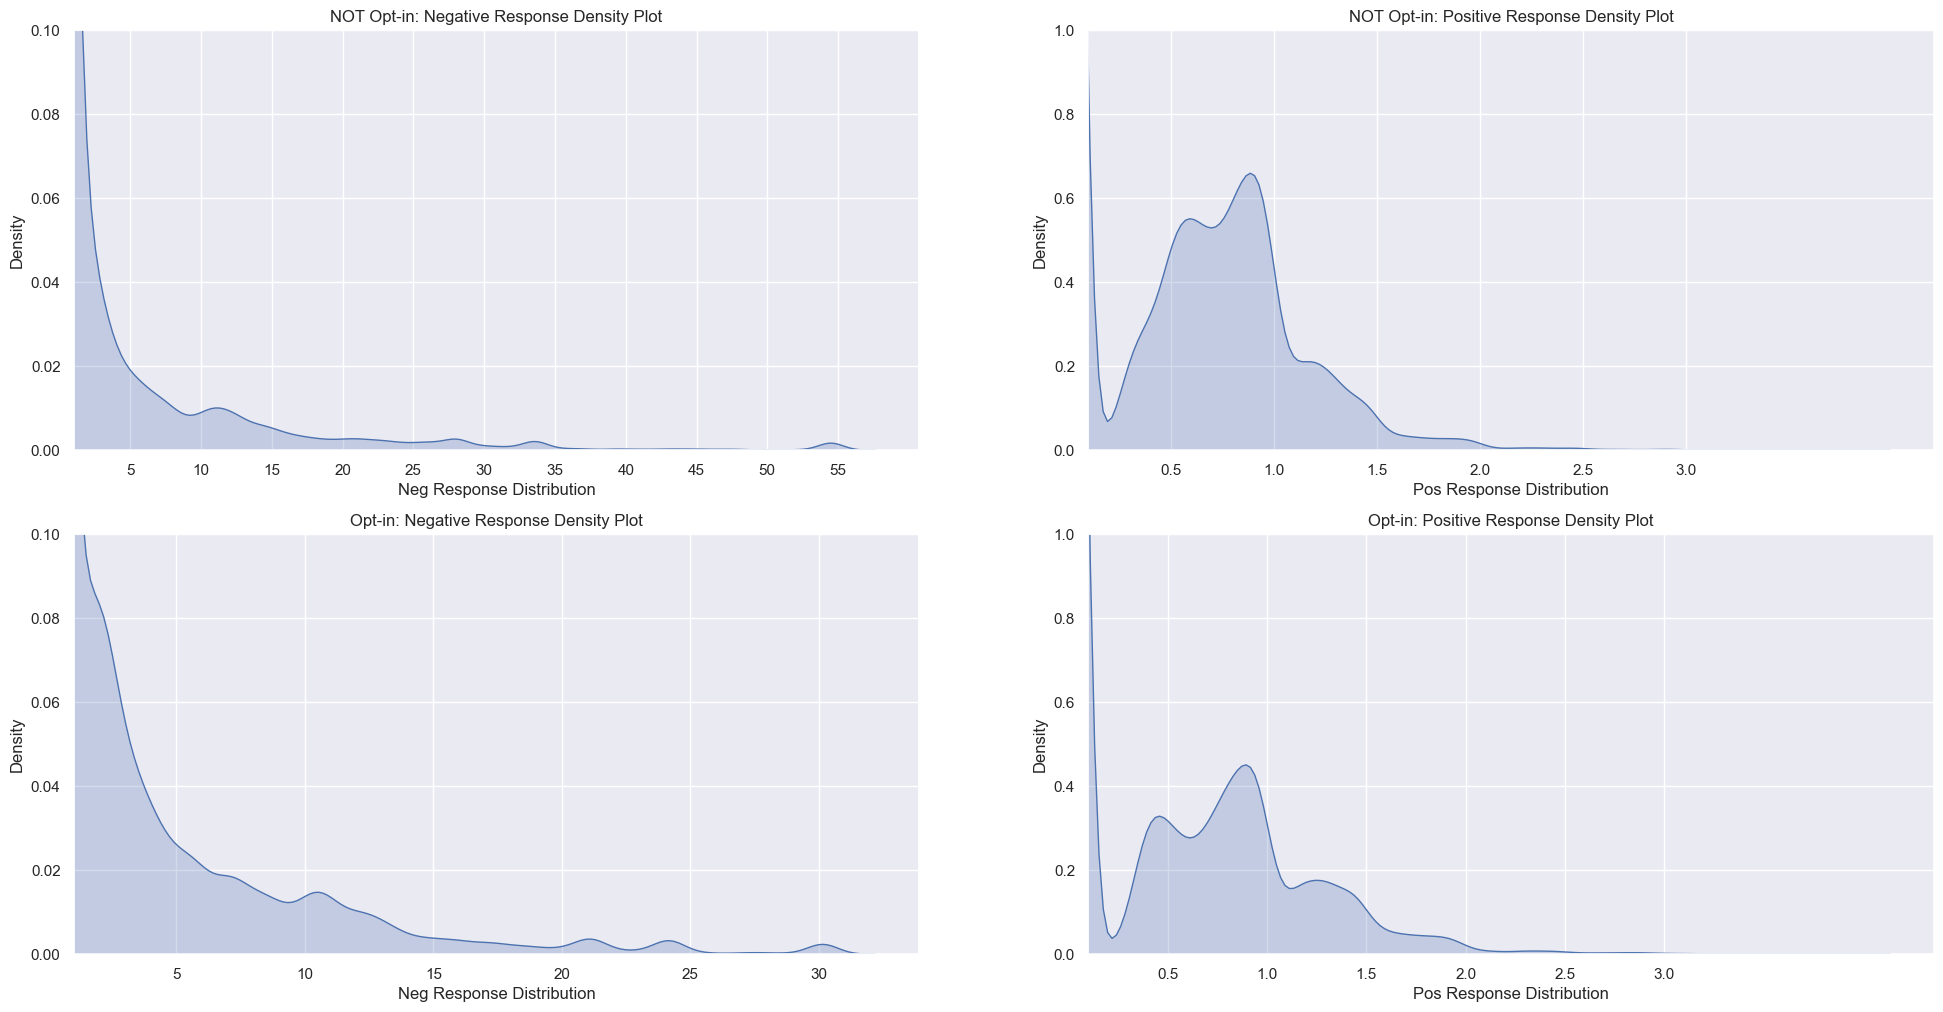

In [323]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 12))

sns.set_theme(style="darkgrid")
sns.kdeplot(data = df_not_opt_in['Extreme_Neg_Response'], fill=True,ax=ax1)
ax1.set_xlabel('Neg Response Distribution')
ax1.set_title('NOT Opt-in: Negative Response Density Plot')
ax1.set_xticks(np.linspace(0, 55, num=12))
ax1.set_xlim(1, None)
ax1.set_ylim(None,.1)


sns.kdeplot(data = df_not_opt_in['Extreme_Pos_Response'], fill=True,ax=ax2)
ax2.set_xlabel('Pos Response Distribution')
ax2.set_title('NOT Opt-in: Positive Response Density Plot')
ax2.set_xticks(np.linspace(0, 3, num=7))
ax2.set_xlim(.1, None)
ax2.set_ylim(None,1)

sns.set_theme(style="darkgrid")
sns.kdeplot(data = df_opt_in['Extreme_Neg_Response'], fill=True,ax=ax3)
ax3.set_xlabel('Neg Response Distribution')
ax3.set_title('Opt-in: Negative Response Density Plot')
ax3.set_xticks(np.linspace(0, 30, num=7))
ax3.set_xlim(1, None)
ax3.set_ylim(None,.1)


sns.kdeplot(data = df_opt_in['Extreme_Pos_Response'], fill=True,ax=ax4)
ax4.set_xlabel('Pos Response Distribution')
ax4.set_title('Opt-in: Positive Response Density Plot')
ax4.set_xticks(np.linspace(0, 3, num=7))
ax4.set_xlim(.1, None)
ax4.set_ylim(None,1)

plt.show()

#### In order to dig deeper to see if a model can be used to predict the Opt_in label. I decided to use a [ROC - AUC score](https://builtin.com/data-science/roc-curves-auc) which helps to quantify the perfromance of a classification model to predict true positives. The closer the score is to 1 the better the model is performing with a score of .5 being erquavalent to random geussing.  

In [337]:
#Neg ROC Score
neg_responses = df['Extreme_Neg_Response']
labels = df['Opt_in']
roc_score_neg = roc_auc_score(labels, neg_responses)

#Pos ROC Score
pos_responses = df['Extreme_Pos_Response']
labels = df['Opt_in']
roc_score_pos = roc_auc_score(labels, pos_responses)


print("ROC Score: 'Pos Response", roc_score_pos)
print("ROC Score: 'Neg Response", roc_score_neg)

ROC Score: 'Pos Response 0.4450311229529631
ROC Score: 'Neg Response 0.5411004303916555


#### Below are [ROC - AUC curves.](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) As you probably already noticed by the scores this model doesnt perfom much better than flipping a coin. 

ROC Score: 'Pos Response 0.4450311229529631
ROC Score: 'Neg Response 0.5411004303916555


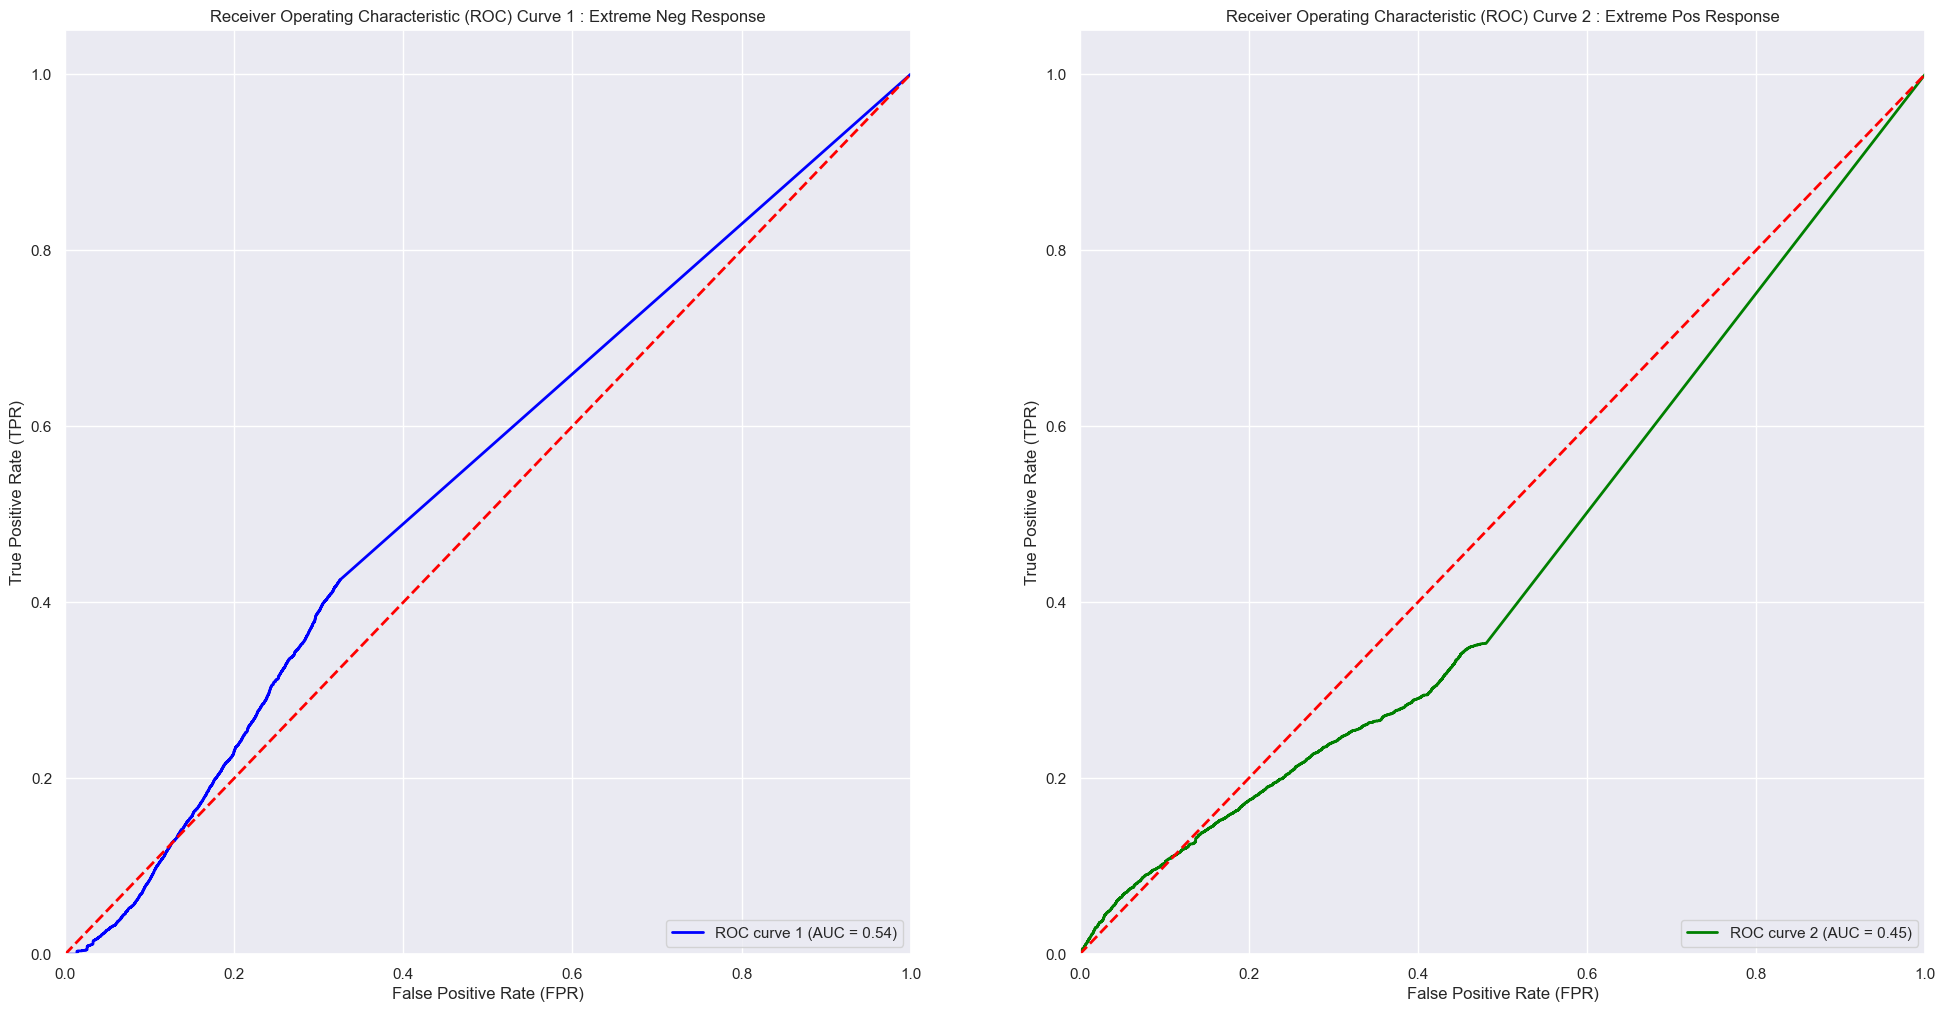

In [334]:

fpr1, tpr1, thresholds1 = roc_curve(labels, neg_responses)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, thresholds2 = roc_curve(labels, pos_responses)
roc_auc2 = auc(fpr2, tpr2)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

#Extreme Neg Response ROC curve
ax1.plot(fpr1, tpr1, color='blue', lw=2, label='ROC curve 1 (AUC = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate (FPR)')
ax1.set_ylabel('True Positive Rate (TPR)')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve 1 : Extreme Neg Response')
ax1.legend(loc="lower right")

# Extreme Pos Response ROC curve
ax2.plot(fpr2, tpr2, color='green', lw=2, label='ROC curve 2 (AUC = %0.2f)' % roc_auc2)
ax2.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('True Positive Rate (TPR)')
ax2.set_title('Receiver Operating Characteristic (ROC) Curve 2 : Extreme Pos Response')
ax2.legend(loc="lower right")
print("ROC Score: 'Pos Response", roc_score_pos)
print("ROC Score: 'Neg Response", roc_score_neg)

In [13]:
# Not-exhaustive project checklist
# Note: this is not a writing assignment, but you should still incorporate comments or headers throughout
# -- This will help others who review your work, but will also help you keep track of what you're doing
# -- Just think about what would help you understand a peer's project when you have to grade theirs later


# 1) Dataset included
# 1a) Dataset explained/documented when used
# 2) Analysis performed
# 2a) Analysis steps documented, explained briefly
# 3) Visualizations/outputs
# 4) Conclusion
# ---Did you answer your questions?
# ---Did you find anything else?
# ---What problems did you run into?
# ---Any suggestions for future research?

# Critical checks before submission
# - Does the noteboook run without error? (Kernel>restart & run all => no errors at all? No long periods of processing?)
# - Do you have your dataset included here? You shouldn't be connecting to any external data
# - - Even if external datasets work here, they WILL NOT work for peer-grading, and you may get a 0.

### Remember: the project rules and rubric are documented in Piazza post @2381. If you have any questions you should ask them there. The checklist above is just an example of a template/workflow we would use.

### You do not need to use this template. You can delete it and upload your own notebook if you want. If you already created a notebook locally, you may upload it directly into Vocareum and delete this one when you submit. Or you may copy your code into here from that notebook, it doesn't make a difference. Your peers will see the entirety of what's in this work area, so the notebook name doesn't matter.